In [13]:
import os
from pathlib import Path
import librosa
import librosa.display
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def feature_extractor(sound_path, window_size):
    # Load the audio file
    signal, sr = librosa.load(sound_path)
    
    # Extract MFCCs
    mfccs = librosa.feature.mfcc(y=signal, n_mfcc=13,sr = sr, hop_length=window_size)
    
    # Extract first MFCCs derivatives
    delta_mfccs = librosa.feature.delta(mfccs)
    
    # Extract second MFCCs derivatives
    delta2_mfccs = librosa.feature.delta(mfccs, order=2)
    
    # Concatenate features
    mfccs_features = np.concatenate((mfccs, delta_mfccs, delta2_mfccs))
    
    # Return all features
    return mfccs, delta_mfccs, delta2_mfccs, mfccs_features


In [14]:
def process_audio_folder(audio_folder,window_size):
    
    # Initialize a list to store individual DataFrames for each audio file
    dfs = []

    # Iterate over each audio file in the folder
    for audio_file in os.listdir(audio_folder):
        # Print the name of the current audio file
        print(audio_file)
        
        # Construct the full path to the audio file
        audio_path = os.path.join(audio_folder, audio_file)
        
        # Extract MFCC features for the current audio file
        # Assuming feature_extractor function is defined elsewhere
        mfcc_features = feature_extractor(audio_path,window_size=window_size)[3]  # Extract the fourth element (mfcc_features)
        transposed_mfcc = mfcc_features.T

        # Create a DataFrame from the transposed array
        df = pd.DataFrame(transposed_mfcc)

        # Add the file name as the first column
        df.insert(0, 'audio_file', os.path.basename(audio_file))

        # Optionally, you can rename the columns if you want
        column_names = ['File Name'] + [f"Feature_{i+1}" for i in range(39)]
        df.columns = column_names

        # Append the dataframe to the list
        dfs.append(df)

    # Concatenate all DataFrames into a single DataFrame
    df_output = pd.concat(dfs, ignore_index=True)
    
    # Return the concatenated DataFrame
    return df_output

# For Generating DF for all Files

In [ ]:
# Run this cell to get processed_df for all the folders
root_folder = "/kaggle/input/language-recognition-vad/FinalDataset"

# Process each language folder in sorted order
# Change window size from here
for language_folder in sorted(os.listdir(root_folder)):
    print(language_folder)
    processed_df = process_audio_folder(os.path.join(root_folder,language_folder), window_size=512)

In [15]:
def process_language_folder_to_csv(language_folder, relative_name, window_size):
    # Process audio files in the language folder
    processed_df = process_audio_folder(language_folder, window_size=window_size)
    # Define the output directory
    output_folder = "/kaggle/working"  # Output directory

    # Check if the output directory exists, if not, create it
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    # Save DataFrame as CSV in the output directory
    output_file = os.path.join(output_folder, relative_name + ".csv")
    processed_df.to_csv(output_file, index=False)


# For Generating all CSV Files

In [ ]:
# Main code
root_folder = "/kaggle/input/language-recognition-vad/FinalDataset"

# Process each language folder in sorted order
# Change window size from here
for language_folder in sorted(os.listdir(root_folder)):
    print(language_folder)
    process_language_folder_to_csv(os.path.join(root_folder, language_folder), language_folder,window_size=512)

# For PCA


In [16]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

class PCA:
    def __init__(self,n_component):
        self.n_component = n_component

    def __covarience_matrix(self,X):
        return X.T.dot(X)

    def __p_component_values(self,COV):
        eigenValues, eigenVectors = np.linalg.eig(COV)
        idx = eigenValues.argsort()[::-1]
        eigenValues = eigenValues[idx]
        eigenVectors = eigenVectors[:, idx]
        return eigenValues, eigenVectors

    def fit(self,X):
        self.COV = self.__covarience_matrix(X)
        self.eigenValues,self.eigenVectors = self.__p_component_values(self.COV)

    def transform(self,X):

        self.eigen_pairs = np.concatenate((np.abs(self.eigenValues).reshape(self.eigenValues.size,1),self.eigenVectors), axis=1)
        self.eigen_pairs = np.array(sorted(self.eigen_pairs, key=lambda a_entry: a_entry[0],reverse = True))
        self.eigenVectors = self.eigen_pairs[:,1:]
        
        if self.n_component > 0:
            eigenVectors = np.delete(self.eigenVectors, range(self.n_component,self.eigenVectors.shape[1]), axis=0)[::-1]
            X_transform = X.dot(eigenVectors.T)

        else:
            raise Exception("Minimum dimension should be more than 0")

        return X_transform

    def fit_transform(self,X):
        self.fit(X)
        return self.transform(X)

def StandardScalar(X, centering=True, scaling=True):
    X = X.astype(float)

    if centering:
        X = X - X.mean(axis = 0)
    if scaling:
        X = X / np.std(X, axis=0)

    return X

def plot_scree_plot(eigen_values, n_components):
    total_variance = np.sum(eigen_values)
    explained_variance_ratio = eigen_values / total_variance * 100
    cumulative_variance_ratio = np.cumsum(explained_variance_ratio)

    plt.figure(figsize=(10, 6))
    plt.bar(range(1, len(eigen_values) + 1), explained_variance_ratio, alpha=0.5, align='center', label='Individual explained variance')
    plt.step(range(1, len(eigen_values) + 1), cumulative_variance_ratio, where='mid', label='Cumulative explained variance')
    plt.ylabel('Explained variance ratio (%)')
    plt.xlabel('Principal components')
    plt.title('Scree Plot')
    plt.xticks(range(1, len(eigen_values) + 1))
    plt.legend(loc='best')
    plt.grid()
    plt.show()

def plot_correlation_heatmap(csv_file_path, exclude_columns=['File Name']):
    # Read the CSV file and exclude specified columns
    df = pd.read_csv(csv_file_path, usecols=lambda column: column not in exclude_columns)
    
    # Calculate the correlation matrix
    corr_matrix = df.corr()

    # Plot the heatmap
    plt.figure(figsize=(20, 16))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix Heatmap')
    plt.show()

In [17]:
def process_csv(csv_file, n_components):
    # Read the CSV file excluding the 'File Name' and 'digit' columns
    df = pd.read_csv(csv_file, usecols=lambda column: column not in ['File Name'])
    df = df.iloc[:,0:13]
    
    # Calculate the correlation matrix
    corr_matrix = df.corr()

    # Plot the heatmap
    plt.figure(figsize=(20, 16))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Correlation Matrix Heatmap')
    plt.show()

    # Extract numeric columns for scaling
    X = df.select_dtypes(include=np.number).values

    X_scaled = StandardScalar(X)

    # Perform principal component analysis
    pca = PCA(n_component=n_components)
    X_transform = pca.fit_transform(X_scaled)
    # Plot the scree plot
    plot_scree_plot(pca.eigenValues, n_components=2)
    return X_transform

# Correlation Scree Plots

In [18]:

import matplotlib.pyplot as plt
# from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from matplotlib.patches import Ellipse
import os
from os.path import isdir, join
from scipy.io import wavfile
from subprocess import check_output
from pathlib import Path
import pandas as pd


# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

# from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

In [19]:

def process_folder(folder_path):
    # Get the list of files in the folder
    files = os.listdir(folder_path)
    
    # Iterate over each file
    for file in files:
        # Check if the file is a CSV file
        if file.endswith('.csv'):
            # Construct the full path to the CSV file
            file_path = os.path.join(folder_path, file)
            
            # Call process_csv function to process the CSV file
            X_transform = process_csv(file_path, 2)
            
            # Print the transformed data or do something else with it
            print(f"Transformed data for {file}:")
            print(X_transform)
            print("=" * 50)
            X_pca = X_transform


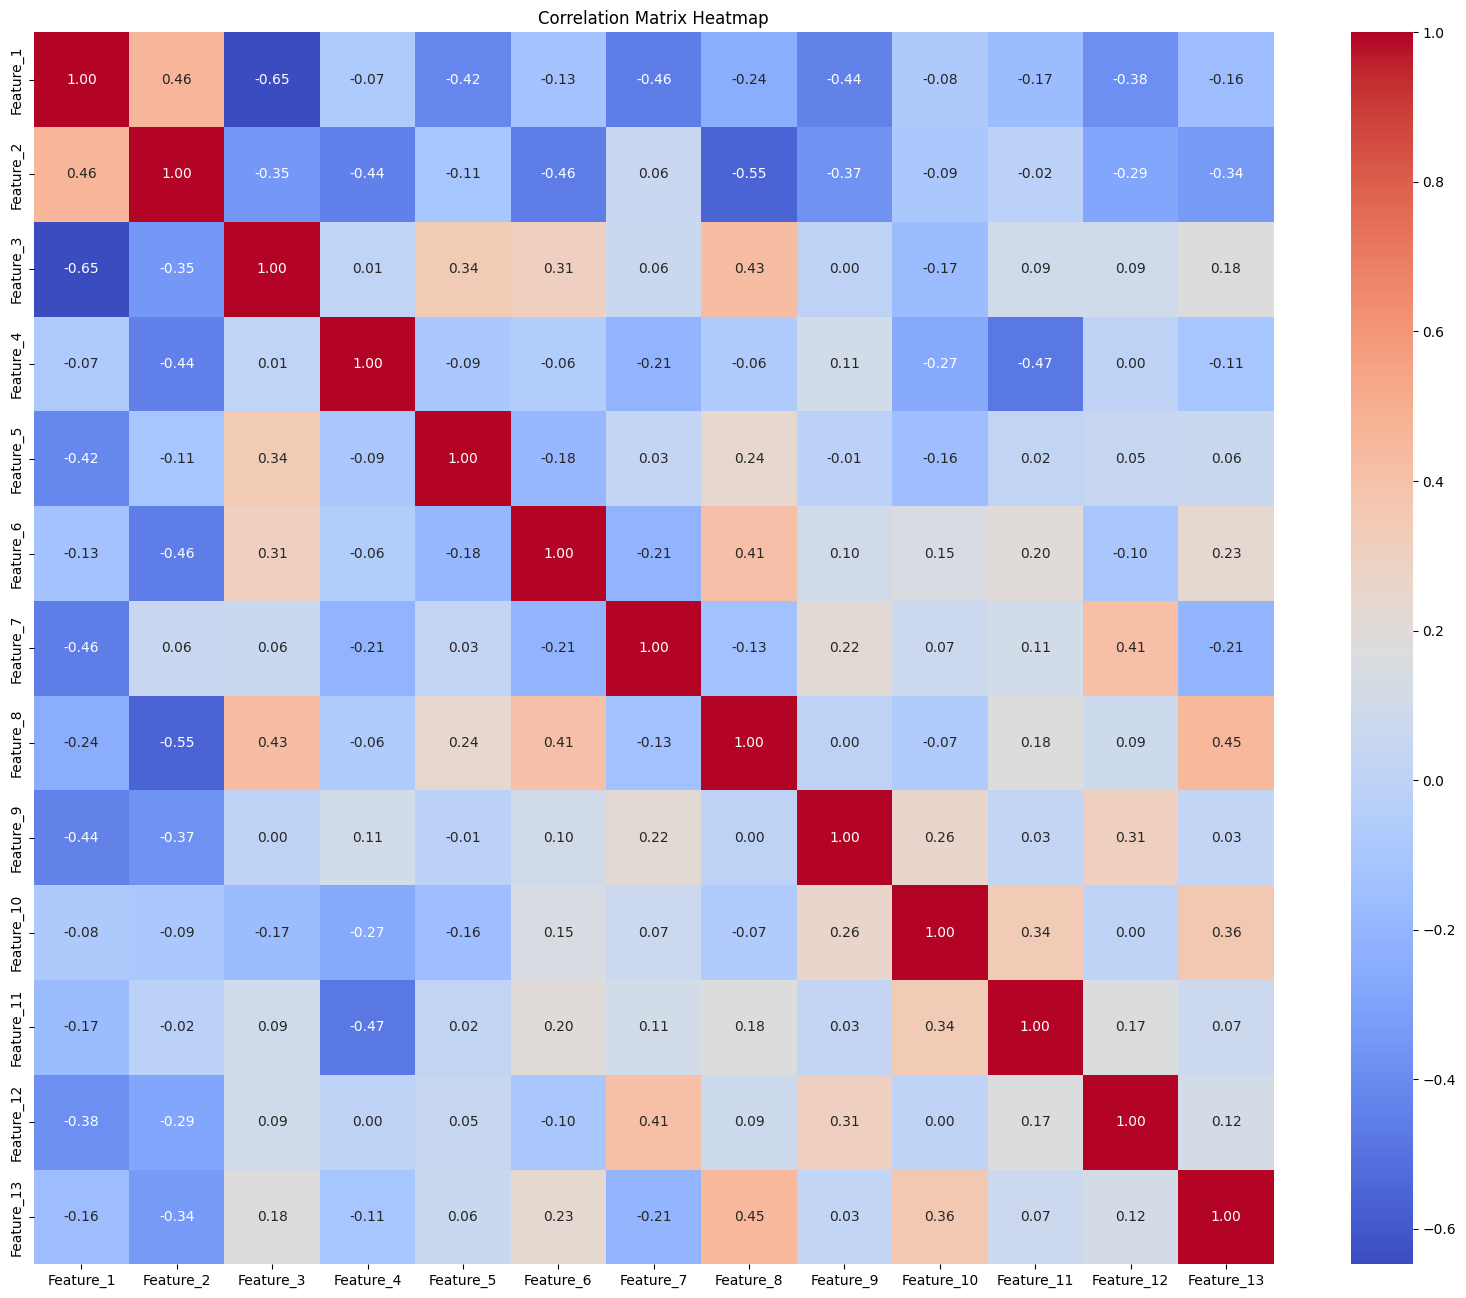

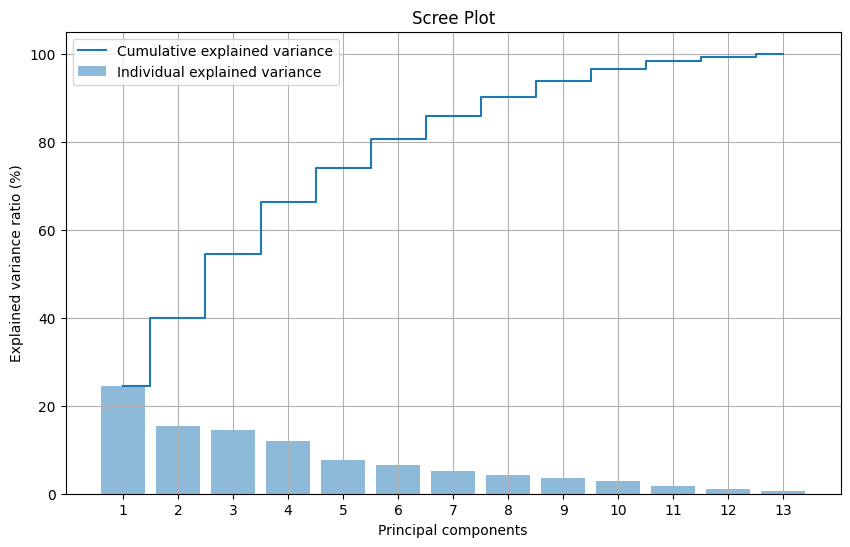

Transformed data for Telugu-Train.csv:
[[ 1.67874463  0.75965541]
 [ 1.44027586  0.79583282]
 [ 0.69999227  0.13880625]
 ...
 [-1.06735884  0.47049334]
 [-1.35784489  0.51129239]
 [-0.82266188  0.03135238]]


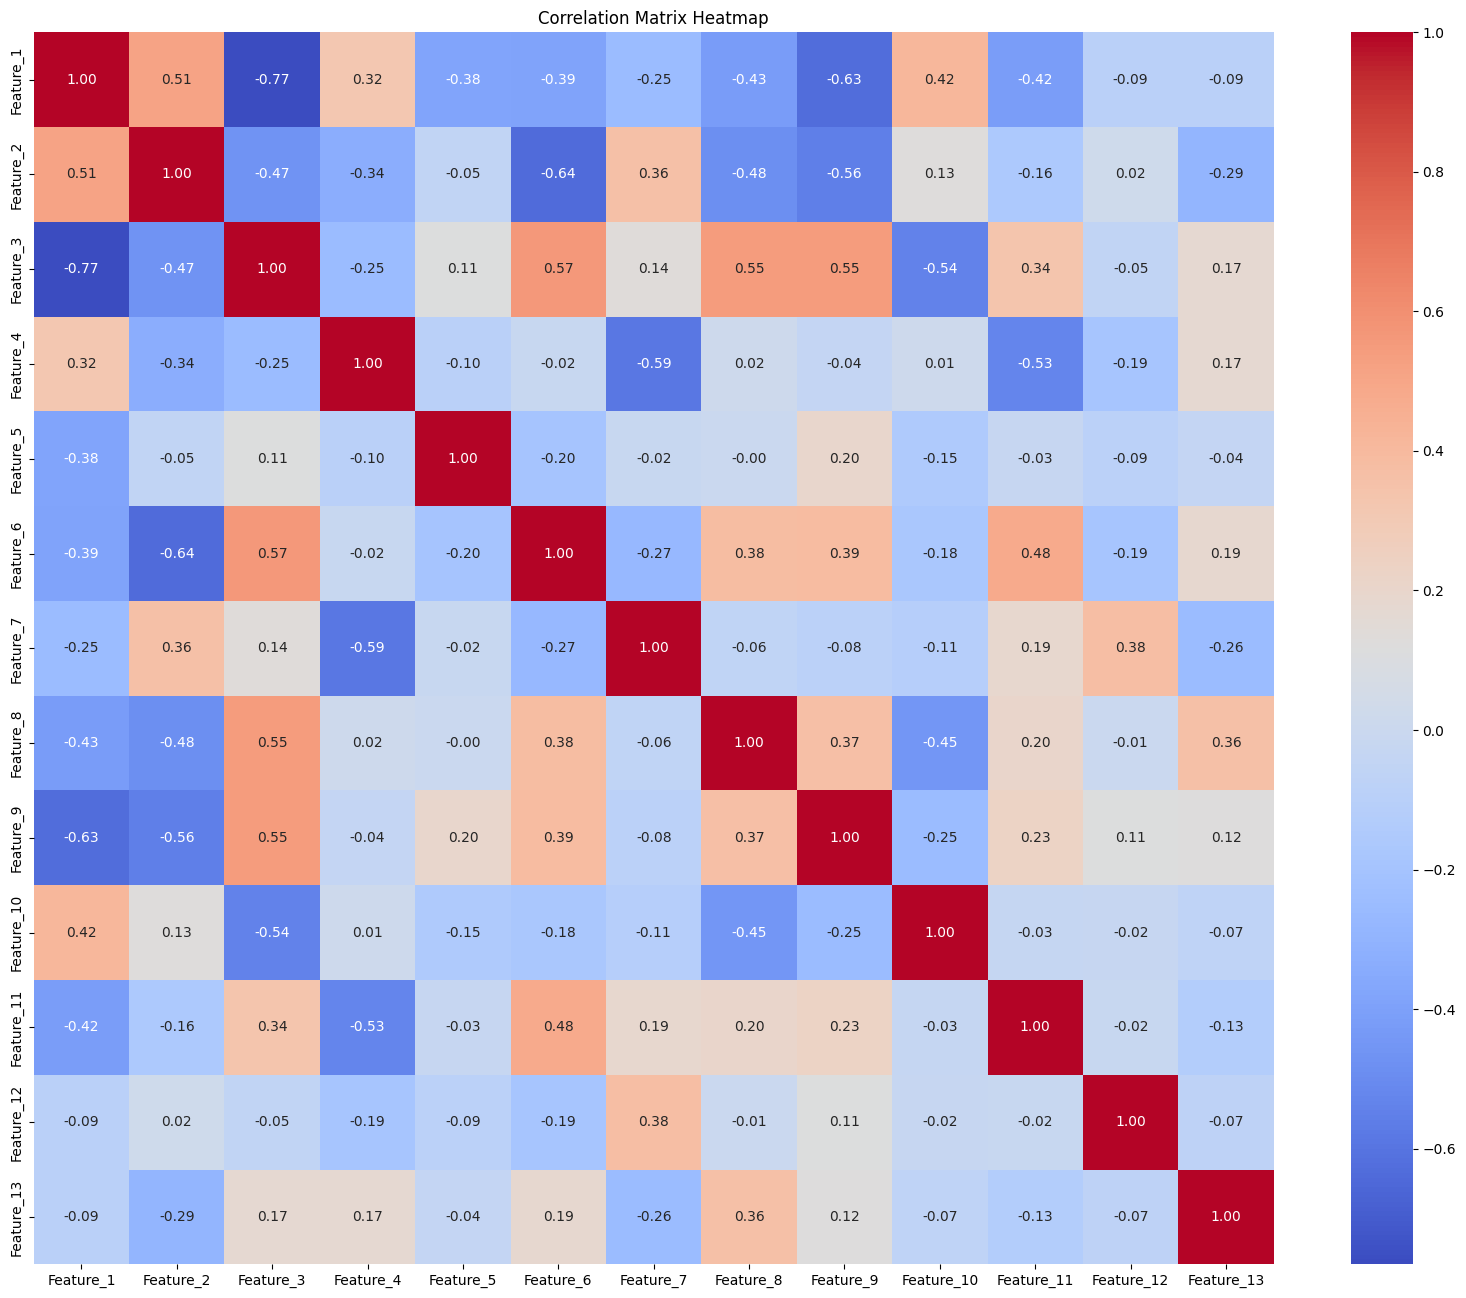

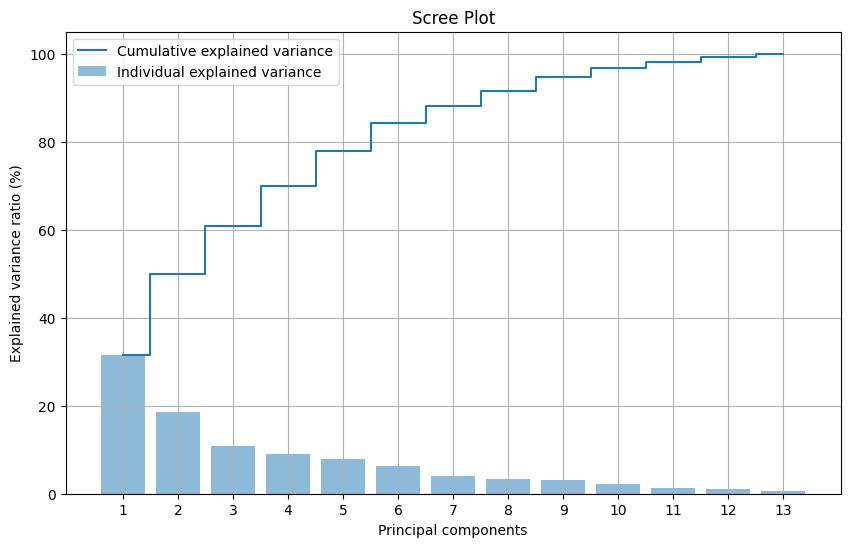

Transformed data for Gujrati-Test.csv:
[[ 3.48342566 -1.34128479]
 [ 2.67504099 -1.42664208]
 [ 0.63466178 -1.50958998]
 ...
 [ 1.58156306  0.85299718]
 [ 1.42254048  1.06673567]
 [ 0.81326334  1.81050283]]


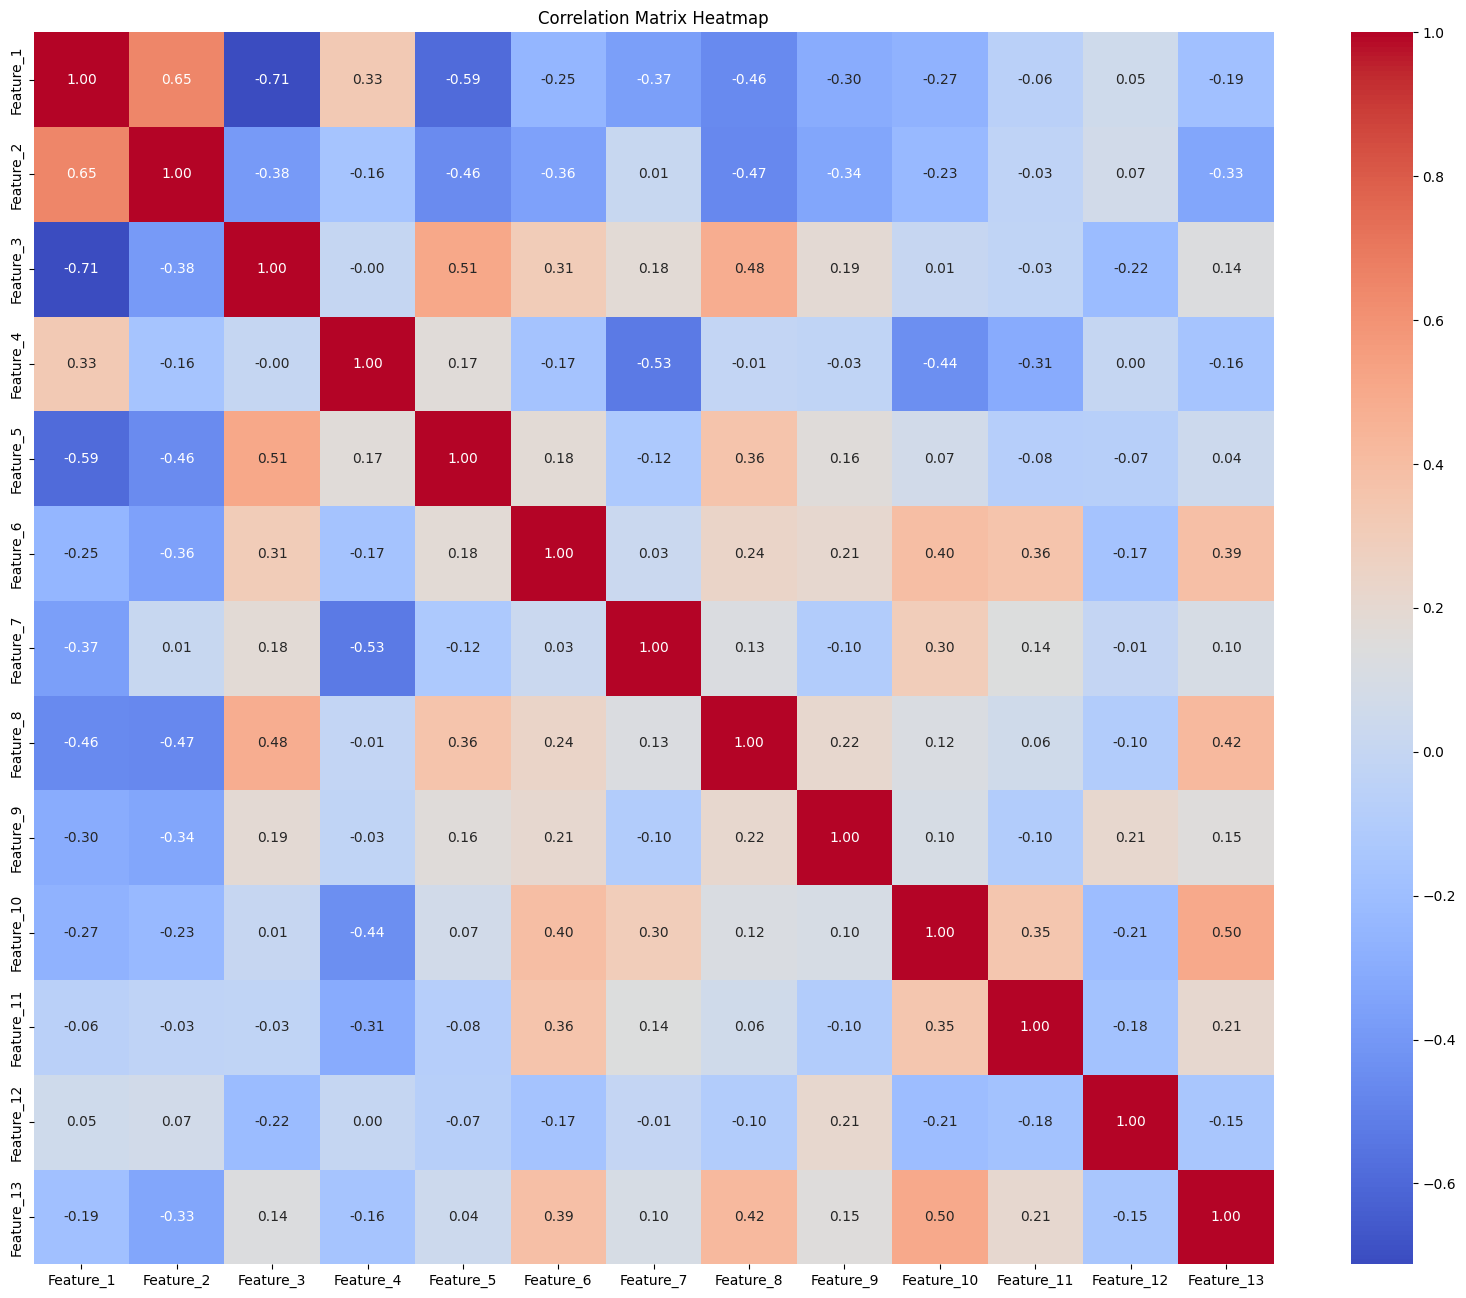

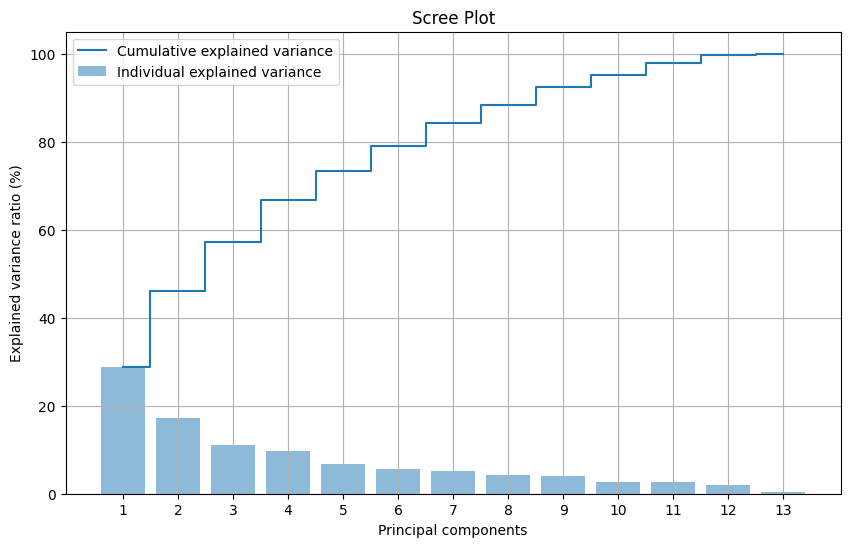

Transformed data for Tamil-Train.csv:
[[-0.64044462  0.01905621]
 [-0.6196102   0.10567305]
 [ 0.44632509 -0.72435116]
 ...
 [-0.40589184 -0.59768906]
 [-0.20340842 -0.94140341]
 [-0.10745924 -0.8808919 ]]


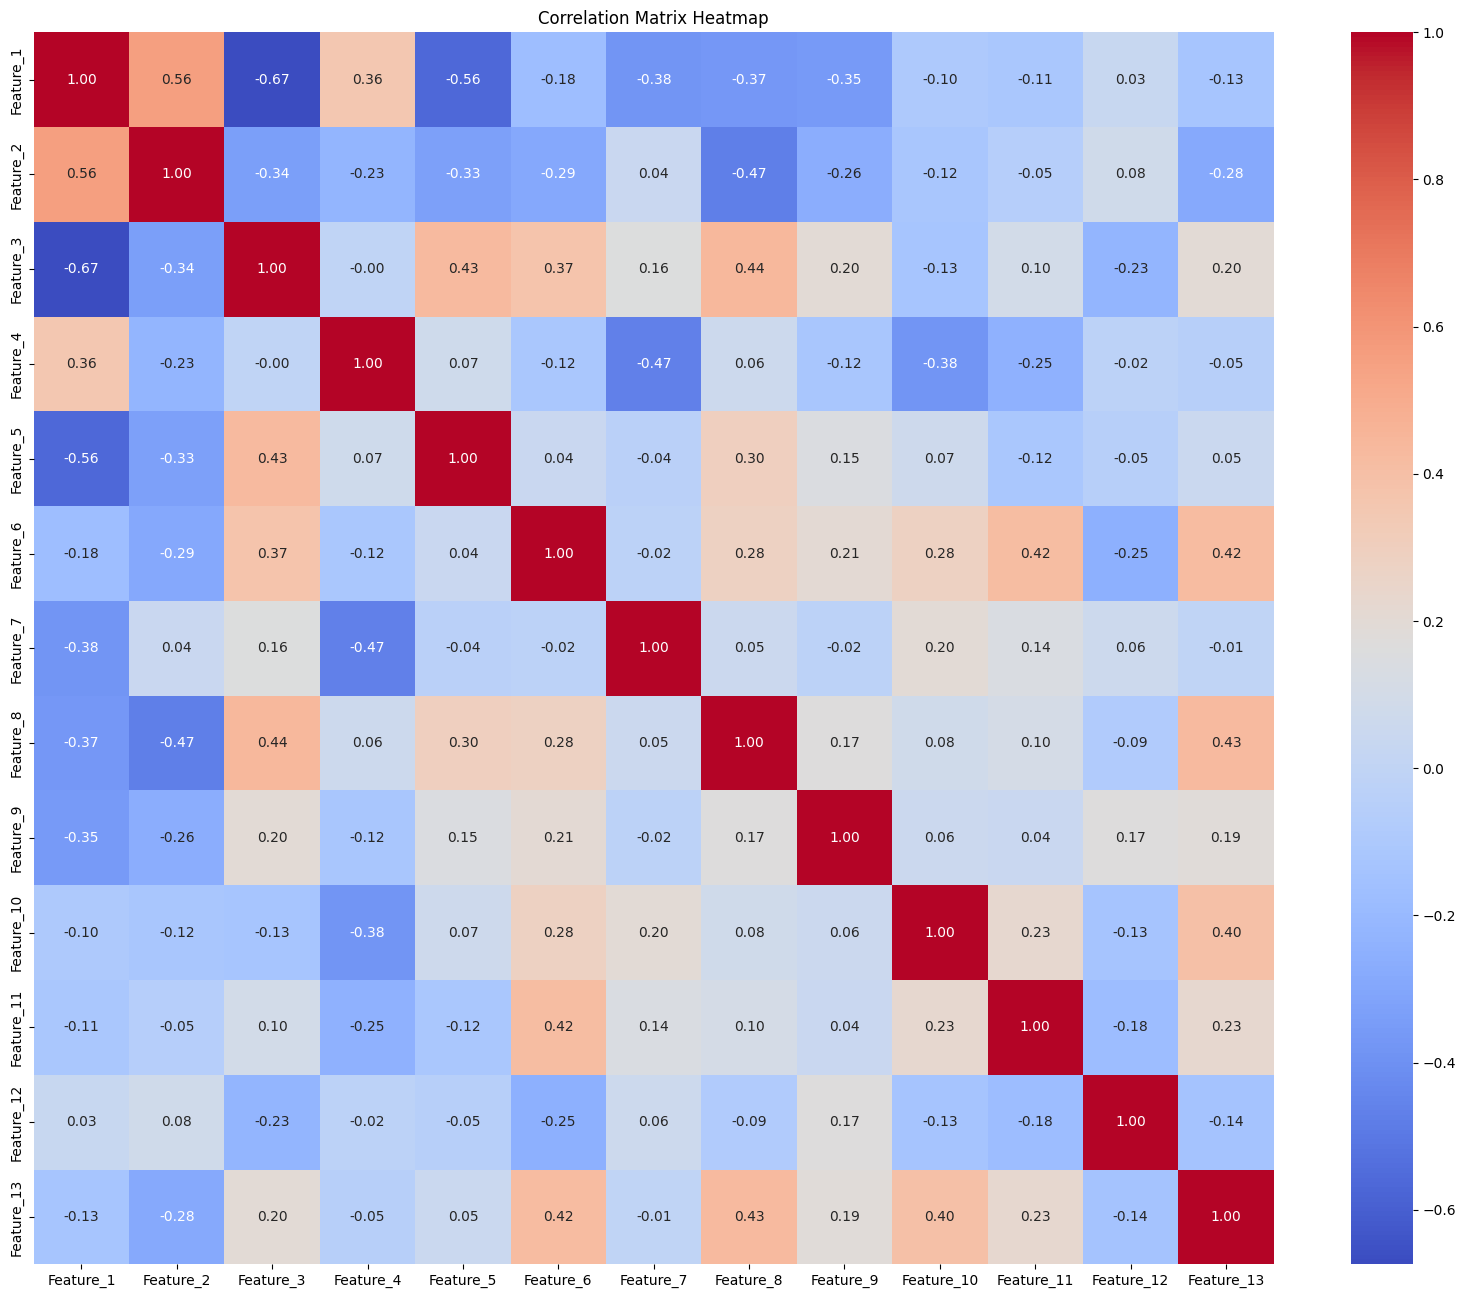

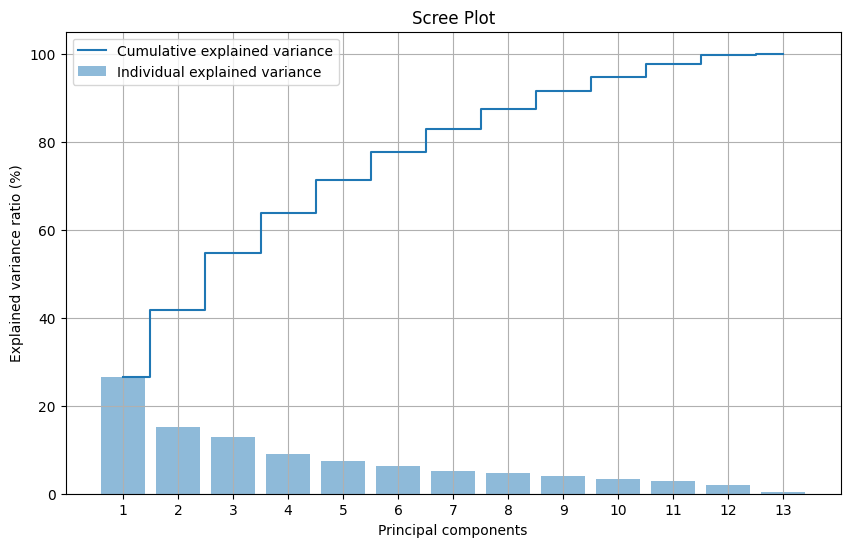

Transformed data for Tamil-Test.csv:
[[ 0.26536718 -0.76429605]
 [ 0.23641024 -0.54618915]
 [ 0.56655919  0.02664355]
 ...
 [ 0.57248181  0.05468316]
 [ 0.56309743 -0.12029317]
 [ 0.64022412  0.16362837]]


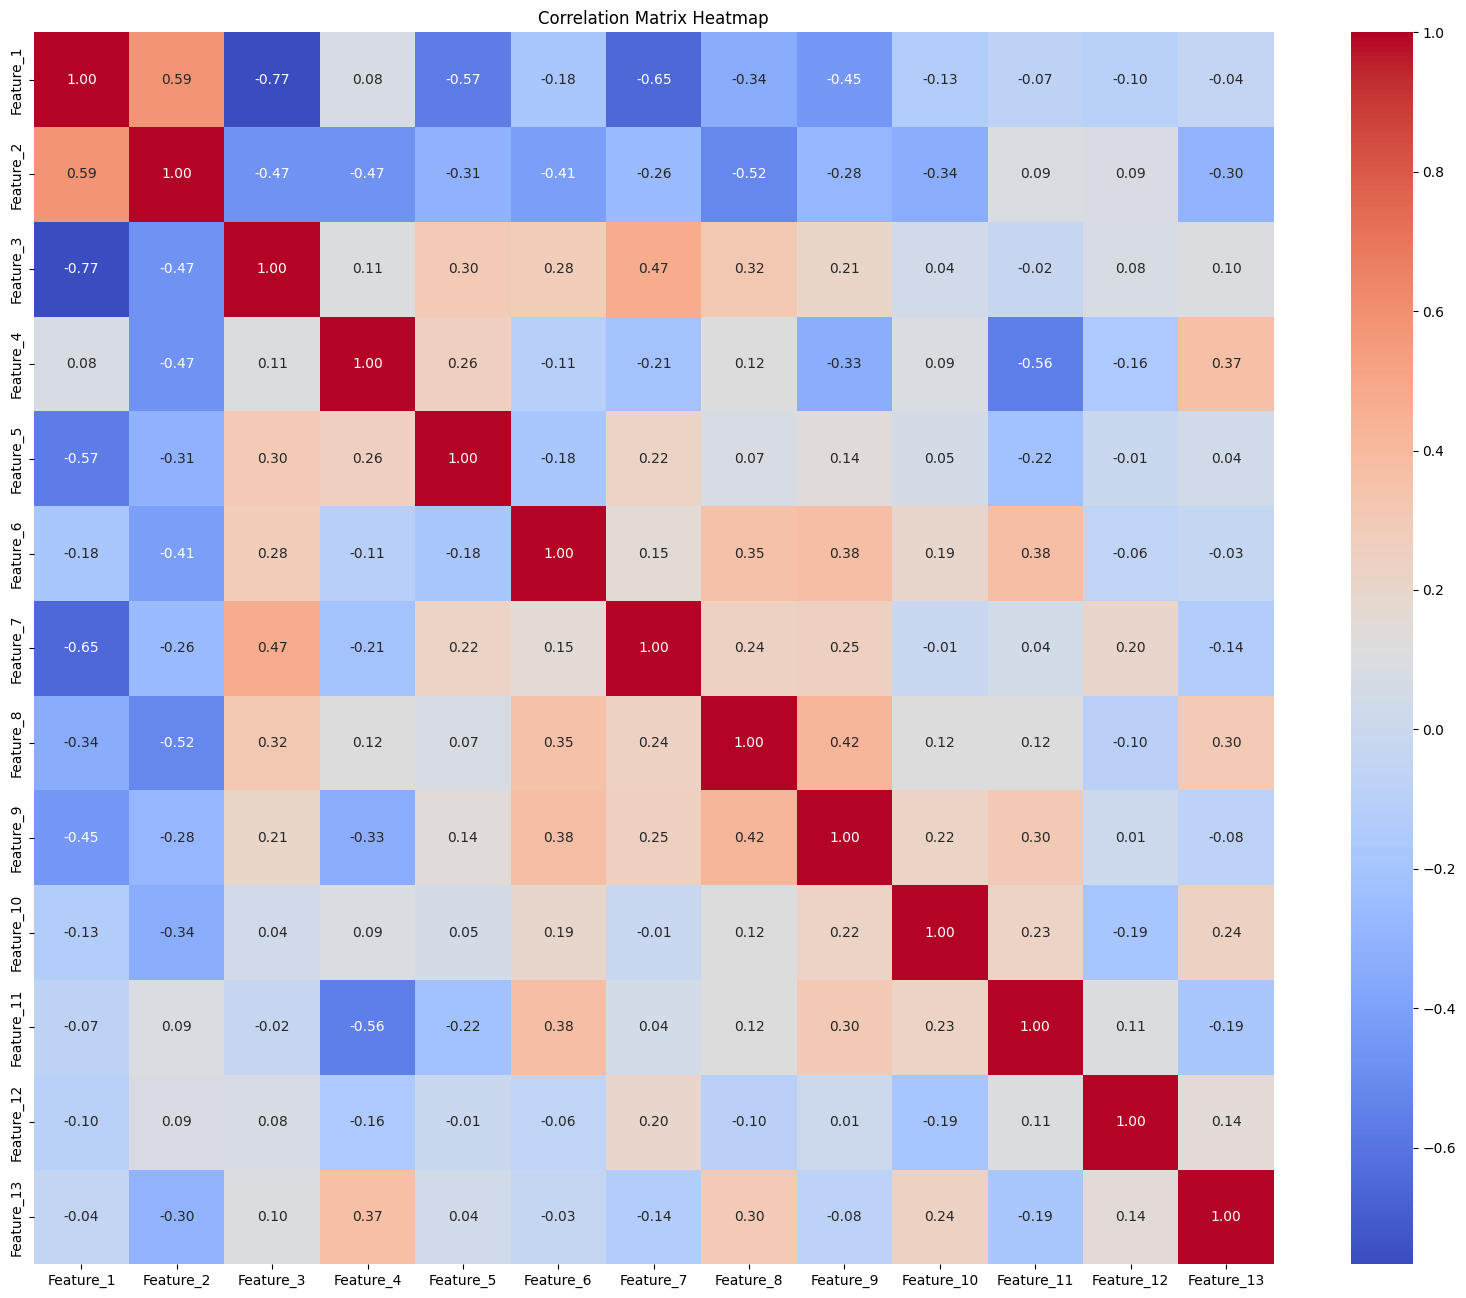

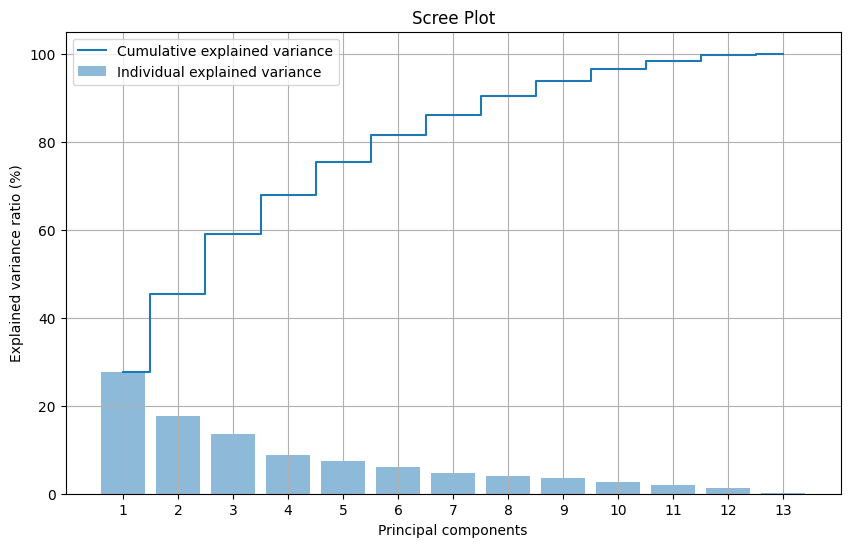

Transformed data for Gujrati-Train.csv:
[[-1.18693137  0.6238302 ]
 [-0.55901497  0.05374998]
 [-0.94619013 -0.73392663]
 ...
 [-0.55711206  0.49687326]
 [-0.96011325  0.73527751]
 [-1.15134525  0.85207143]]


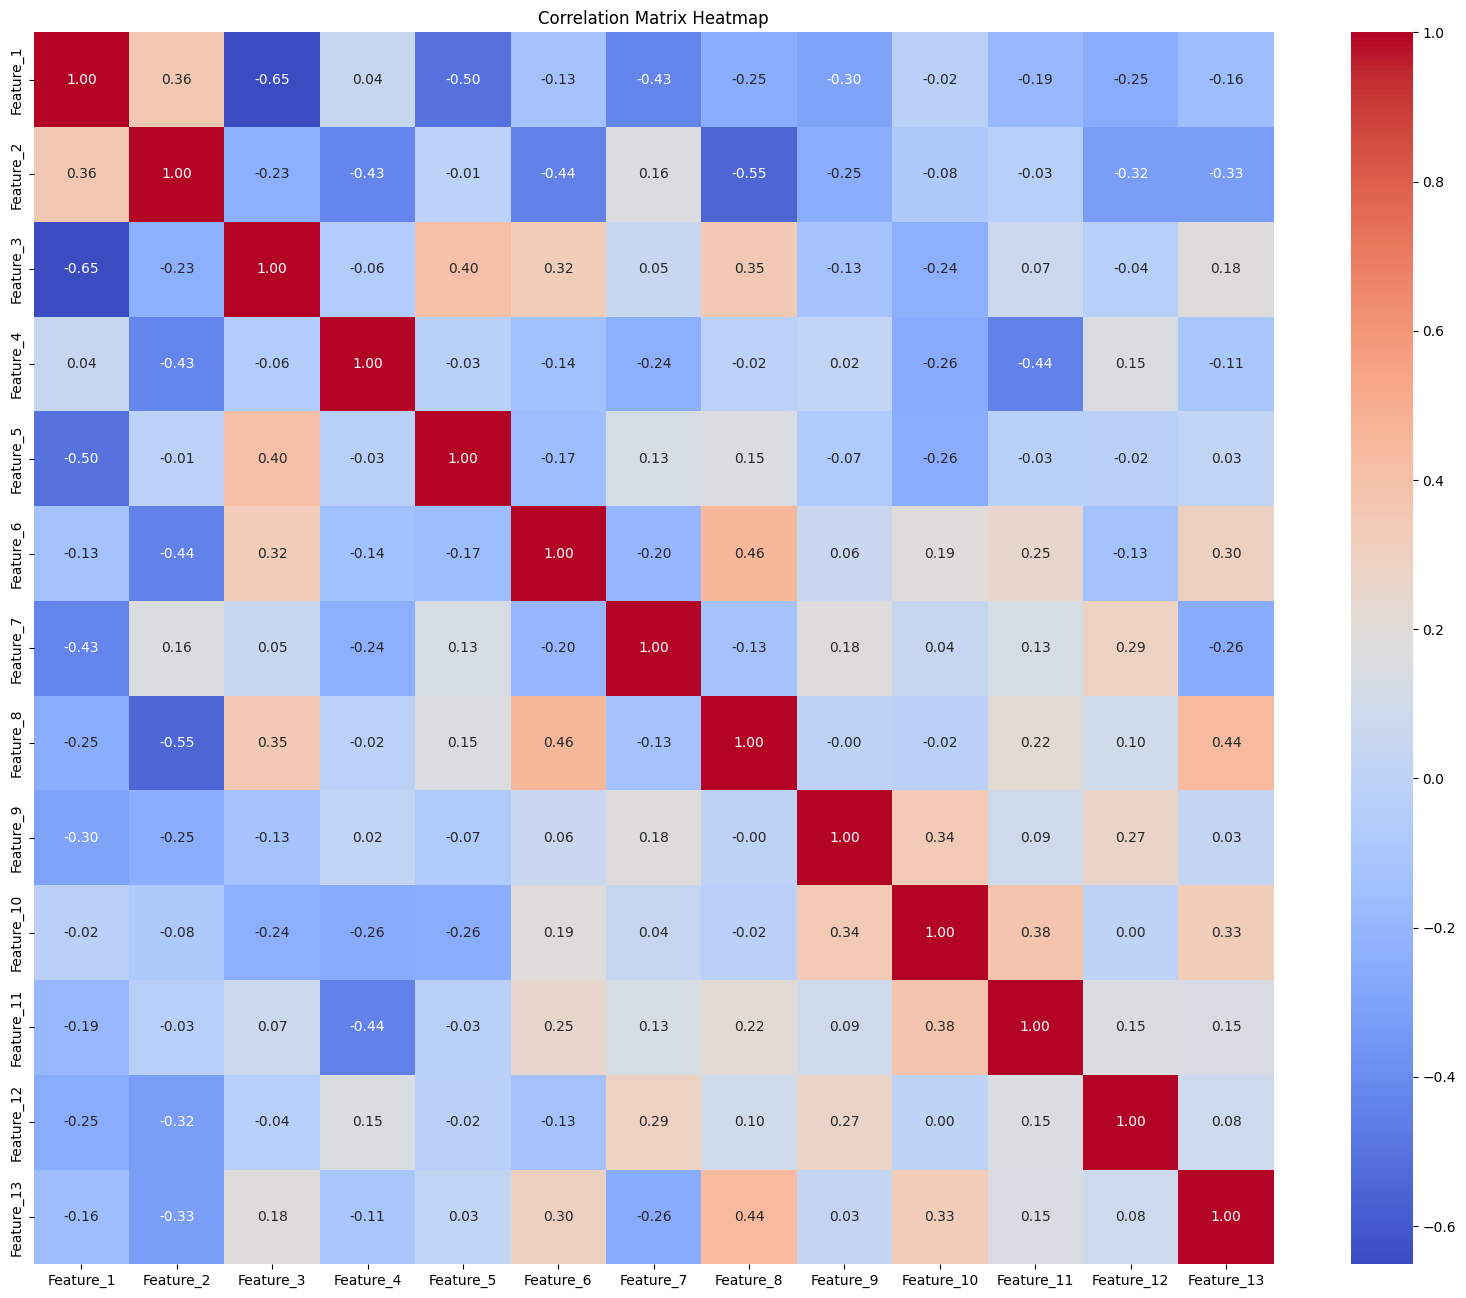

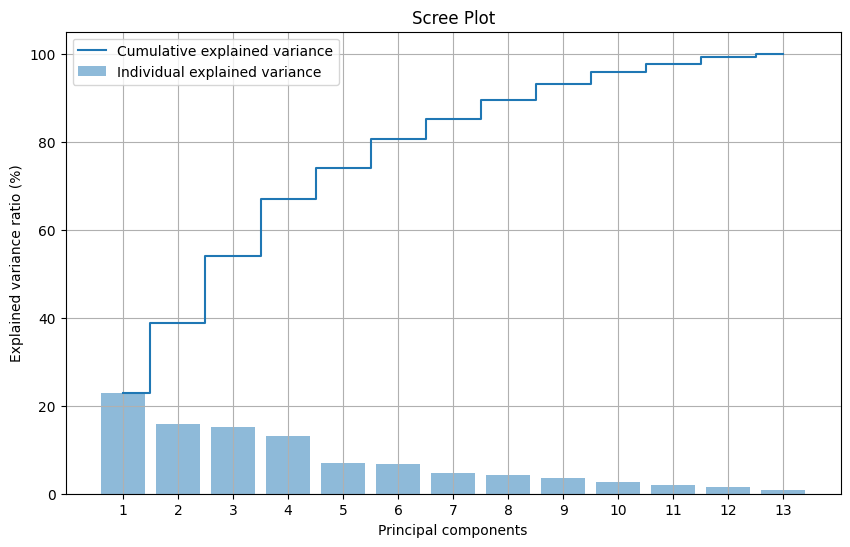

Transformed data for Telugu-Test.csv:
[[-1.96755914 -1.53504376]
 [-1.791317   -1.07696173]
 [ 0.37597223  0.0360749 ]
 ...
 [ 0.8269265  -0.01471017]
 [ 0.78060324  0.15310292]
 [ 0.74508058  0.27717792]]


In [20]:
# Example usage
folder_path = '/kaggle/working'
process_folder(folder_path)


# For VAD 

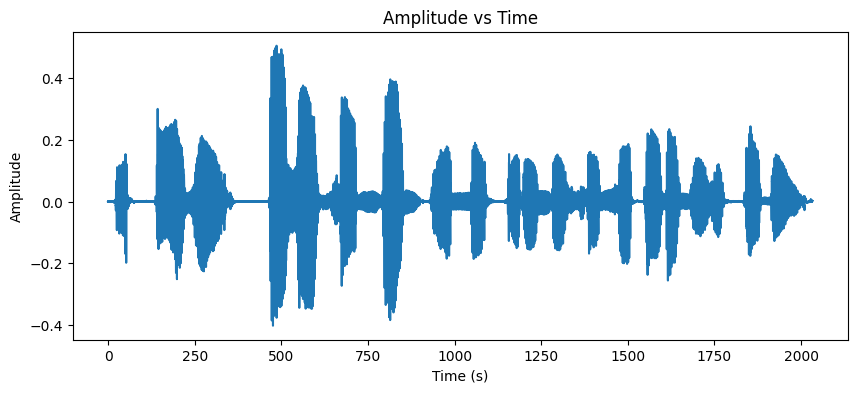

In [11]:
import librosa
import matplotlib.pyplot as plt

# Load the audio file
audio_file = '/kaggle/input/language-recognition/Language-Recognition/Tamil-Train/000020012.wav'
y, sr = librosa.load(audio_file)
y, _= librosa.effects.trim(y, top_db=30)
# Calculate the time array
time = librosa.times_like(y, sr=sr)

# Plot the amplitude vs time
plt.figure(figsize=(10, 4))
plt.plot(time, y)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Amplitude vs Time')
plt.show()


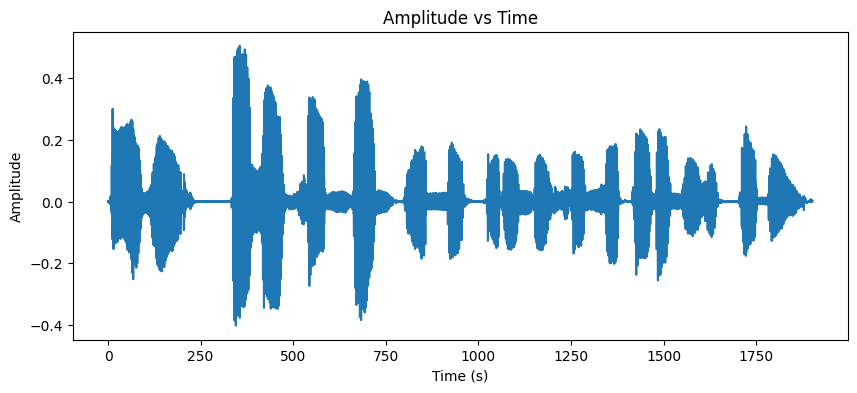

In [12]:
import librosa
import matplotlib.pyplot as plt

# Load the audio file
audio_file = '/kaggle/input/language-recognition-vad/FinalDataset/Tamil-Train/000020012.wav'
y, sr = librosa.load(audio_file)
y, _= librosa.effects.trim(y, top_db=30)
# Calculate the time array
time = librosa.times_like(y, sr=sr)

# Plot the amplitude vs time
plt.figure(figsize=(10, 4))
plt.plot(time, y)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Amplitude vs Time')
plt.show()


In [ ]:
!zip -r /kaggle/working/Final.zip /kaggle/working
